In [1]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import h5py
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
import allel; print(allel.__version__)
%aimport allel.stats.selection

0.21.0.dev0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.3R.h5',
                    mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.haplotypes.3R.h5" (mode r)>

In [4]:
loc_variants = slice(0, 1000000, 1)
n_samples = 50

In [5]:
h1 = allel.GenotypeArray(callset['3R']['calldata/genotype'][loc_variants, :n_samples]).to_haplotypes()
h1

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [6]:
h2 = allel.GenotypeArray(callset['3R']['calldata/genotype'][loc_variants, -n_samples:]).to_haplotypes()
h2

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [7]:
pos = callset['3R']['variants/POS'][loc_variants]
pos

array([   1252,    1262,    1271, ..., 3808745, 3808748, 3808749], dtype=int32)

In [8]:
ac1 = h1.count_alleles(max_allele=1)
ac2 = h2.count_alleles(max_allele=1)
ac = allel.AlleleCountsArray(ac1 + ac2)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 1)
h1_seg = h1.compress(is_seg, axis=0)
h2_seg = h2.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
ac1_seg = ac1.compress(is_seg, axis=0)
ac2_seg = ac2.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

206253

In [9]:
%%time
score_0min = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0, include_edges=True, use_threads=False, max_gap=10000, clip_gap=1000)

CPU times: user 47.9 s, sys: 4 ms, total: 47.9 s
Wall time: 47.8 s


In [10]:
%%time
score = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, include_edges=True, use_threads=False, max_gap=100000, clip_gap=1000)

CPU times: user 10.4 s, sys: 4 ms, total: 10.4 s
Wall time: 10.4 s


In [11]:
%%time
score_threaded = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, include_edges=True, use_threads=True, max_gap=100000, clip_gap=1000)

CPU times: user 12.4 s, sys: 8 ms, total: 12.4 s
Wall time: 3.32 s


In [12]:
score

array([        nan, -0.34142822, -0.42965751, ...,  0.18381358,
        0.17693078,         nan])

In [13]:
score_threaded

array([        nan, -0.34142822, -0.42965751, ...,  0.18381358,
        0.17693078,         nan])

In [14]:
np.count_nonzero(np.isnan(score)), np.count_nonzero(~np.isnan(score))

(2, 206251)

In [15]:
np.count_nonzero(np.isinf(score)), np.count_nonzero(~np.isinf(score))

(0, 206253)

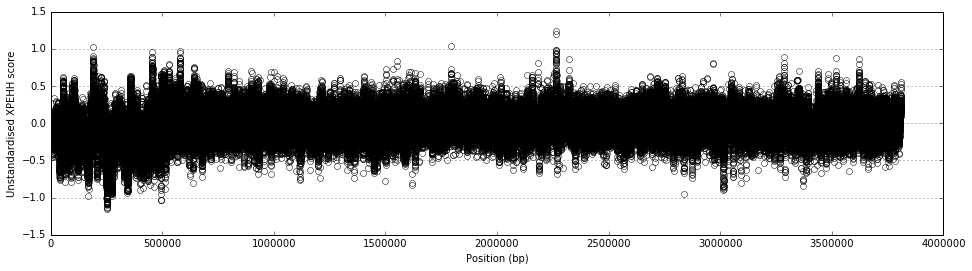

In [16]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('Position (bp)')
plt.ylabel('Unstandardised XPEHH score');

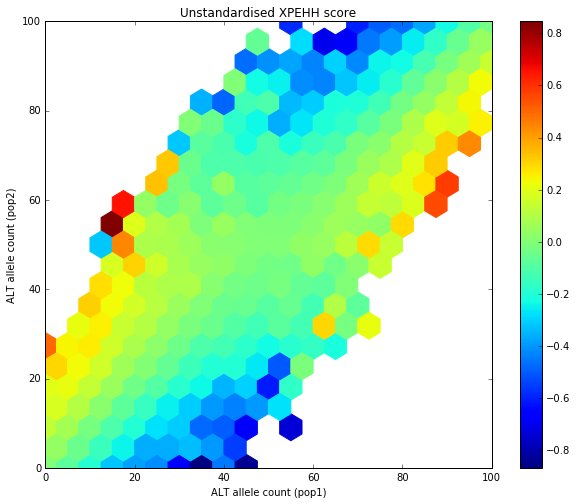

In [17]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
C = score
plt.figure(figsize=(10, 8))
plt.hexbin(x, y, C, gridsize=20)
plt.colorbar()
plt.xlabel('ALT allele count (pop1)')
plt.ylabel('ALT allele count (pop2)')
plt.title('Unstandardised XPEHH score');

In [18]:
score_standardized = allel.stats.standardize(score)

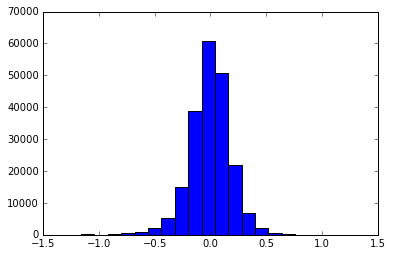

In [19]:
plt.hist(score[~np.isnan(score)], bins=20);

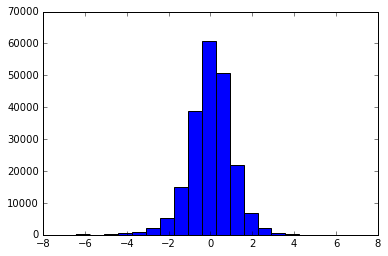

In [20]:
plt.hist(score_standardized[~np.isnan(score_standardized)], bins=20);

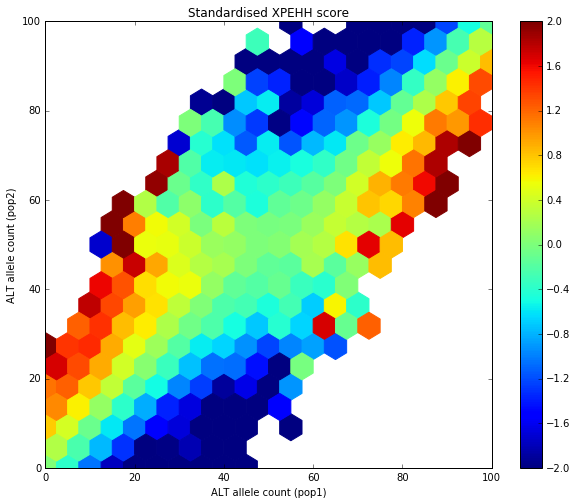

In [21]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
C = score_standardized
plt.figure(figsize=(10, 8))
plt.hexbin(x, y, C, gridsize=20, vmin=-2, vmax=2)
plt.colorbar()
plt.xlabel('ALT allele count (pop1)')
plt.ylabel('ALT allele count (pop2)')
plt.title('Standardised XPEHH score');

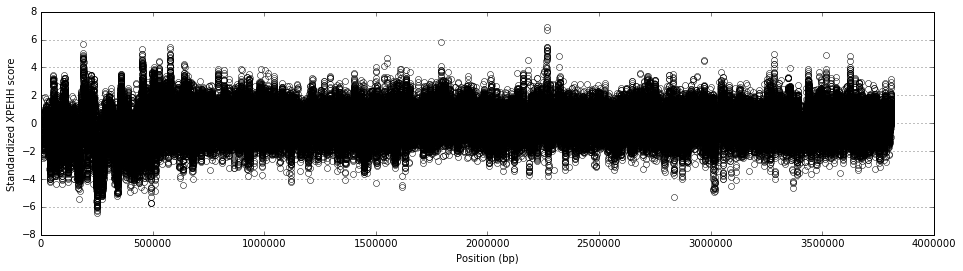

In [33]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score_standardized, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('Position (bp)')
plt.ylabel('Standardized XPEHH score');

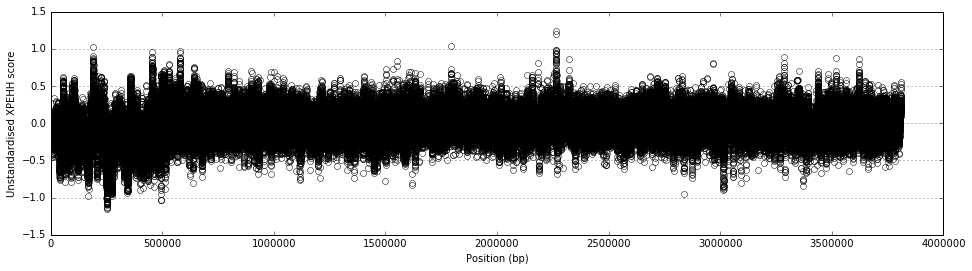

In [34]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('Position (bp)')
plt.ylabel('Unstandardised XPEHH score');

In [35]:
cProfile.run('allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, include_edges=True, use_threads=False)', sort='time')

         140 function calls in 9.371 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    9.364    2.341    9.364    2.341 stats.pyx:527(ihh_scan_int8)
        1    0.007    0.007    9.371    9.371 selection.py:265(xpehh)
        1    0.000    0.000    9.371    9.371 {built-in method builtins.exec}
        9    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.array}
       20    0.000    0.000    0.000    0.000 stringsource:341(__cinit__)
        1    0.000    0.000    9.371    9.371 <string>:1(<module>)
        4    0.000    0.000    9.364    2.341 {allel.opt.stats.ihh_scan_int8}
        2    0.000    0.000    0.000    0.000 ndarray.py:1776(__new__)
        7    0.000    0.000    0.000    0.000 numeric.py:414(asarray)
        4    0.000    0.000    0.000    0.000 stringsource:985(memoryview_fromslice)
        2    0.000    0.000    0.000    0.000 ndarray.py:1810(__getitem__)
       16    0.00

## Gap handling

In [25]:
loc_variants = slice(4000000, 9000000, 1)
n_samples = 50

h1 = allel.GenotypeArray(callset['3R']['calldata/genotype'][loc_variants, :n_samples]).to_haplotypes()
h2 = allel.GenotypeArray(callset['3R']['calldata/genotype'][loc_variants, -n_samples:]).to_haplotypes()

In [26]:
pos = callset['3R']['variants/POS'][loc_variants]
pos

array([16532852, 16532853, 16532854, ..., 42555205, 42555210, 42555213], dtype=int32)

In [27]:
ac1 = h1.count_alleles(max_allele=1)
ac2 = h2.count_alleles(max_allele=1)
ac = allel.AlleleCountsArray(ac1 + ac2)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 10)
h1_seg = h1.compress(is_seg, axis=0)
h2_seg = h2.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
ac1_seg = ac1.compress(is_seg, axis=0)
ac2_seg = ac2.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

351867

In [28]:
accessibility = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/accessibility/accessibility.h5', mode='r')
is_accessible = accessibility['3R']['is_accessible'][:]
is_accessible

array([False, False, False, ..., False, False, False], dtype=bool)

In [29]:
def plot_score_gap(score, pos, ylim=(-15, 15)):

    fig = plt.figure(figsize=(16, 4))

    ax = fig.add_subplot(111)
    ax.plot(pos, score, linestyle=' ', marker='o', mfc='none')
    ax.grid(axis='y')
    ax.set_xlabel('position (bp)')
    ax.set_ylabel('score')
    ax.set_ylim(*ylim)

    ax = ax.twinx()
    x = (pos[:-1] + pos[1:]) / 2
    y = np.diff(pos)
    ax.plot(x, y)
    ax.set_ylabel('gap size (bp)')
    ax.autoscale(axis='x', tight=True);

In [30]:
score_unadjusted = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, max_gap=-1, clip_gap=-1)
score_unadjusted = allel.stats.standardize(score_unadjusted)

In [31]:
score_gap_adjusted = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, max_gap=200000, clip_gap=1000)
score_gap_adjusted = allel.stats.standardize(score_gap_adjusted)

In [32]:
score_access_adjusted = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, max_gap=-1, clip_gap=-1, is_accessible=is_accessible)
score_access_adjusted = allel.stats.standardize(score_access_adjusted)

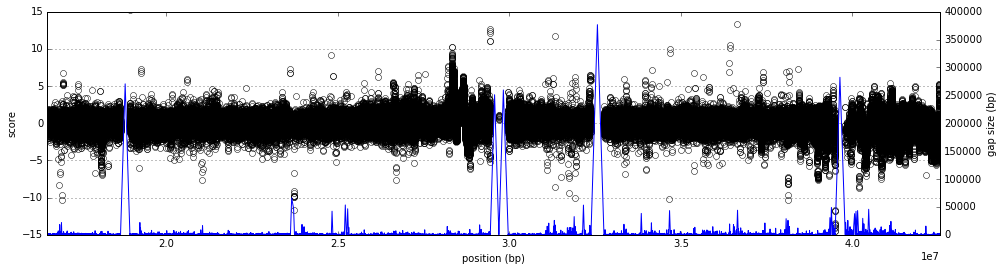

In [33]:
plot_score_gap(score_unadjusted, pos_seg)

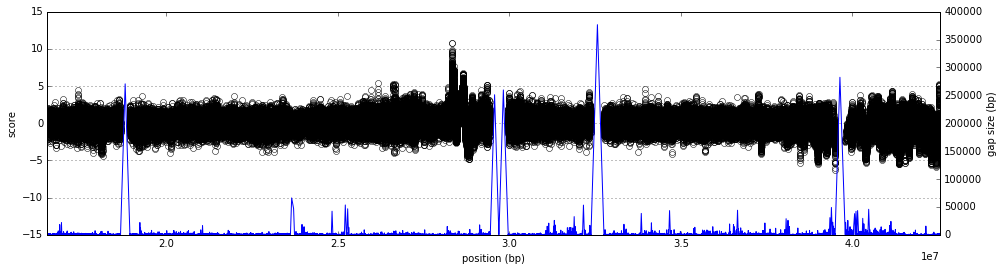

In [34]:
plot_score_gap(score_gap_adjusted, pos_seg)

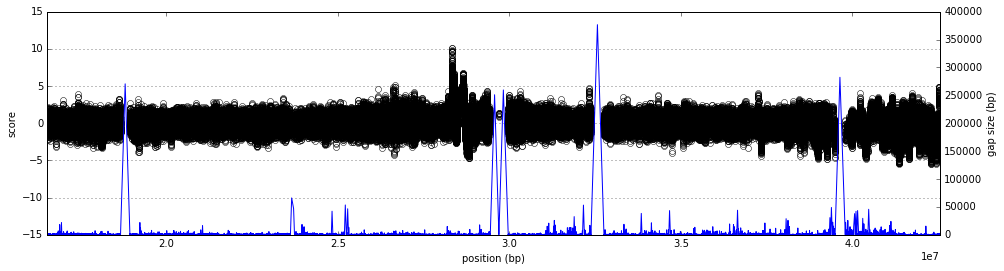

In [35]:
plot_score_gap(score_access_adjusted, pos_seg)

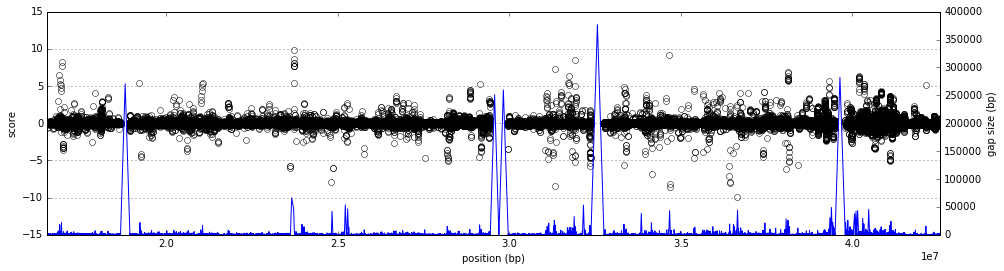

In [36]:
plot_score_gap(score_gap_adjusted - score_unadjusted, pos_seg)

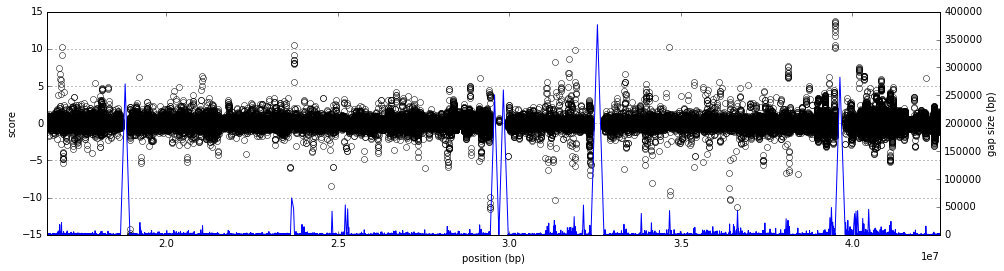

In [37]:
plot_score_gap(score_access_adjusted - score_unadjusted, pos_seg)

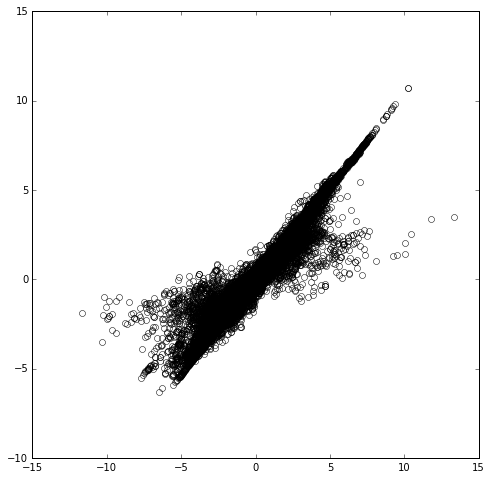

In [38]:
plt.figure(figsize=(8, 8))
plt.plot(score_unadjusted, score_gap_adjusted, marker='o', mfc='none', linestyle=' ');

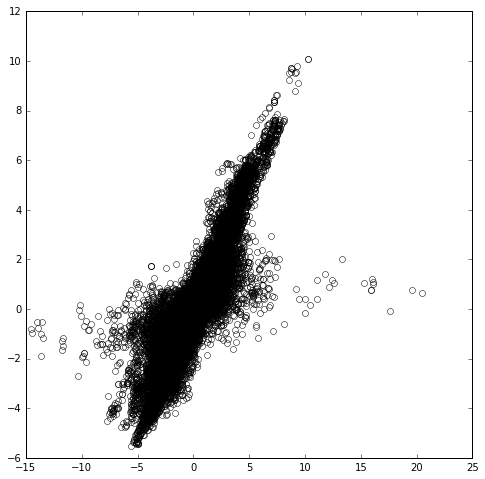

In [39]:
plt.figure(figsize=(8, 8))
plt.plot(score_unadjusted, score_access_adjusted, marker='o', mfc='none', linestyle=' ');

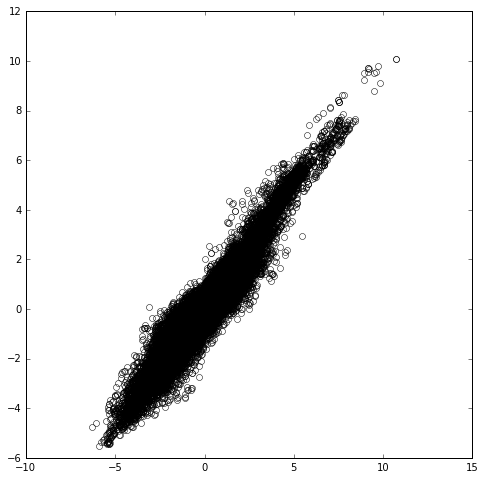

In [40]:
plt.figure(figsize=(8, 8))
plt.plot(score_gap_adjusted, score_access_adjusted, marker='o', mfc='none', linestyle=' ');

## Visualisation

In [49]:
num, den = allel.stats.hudson_fst(ac1_seg, ac2_seg)
fst = num / den
fst[fst < 0] = 0

In [50]:
score_access_adjusted.shape, fst.shape

((351867,), (351867,))

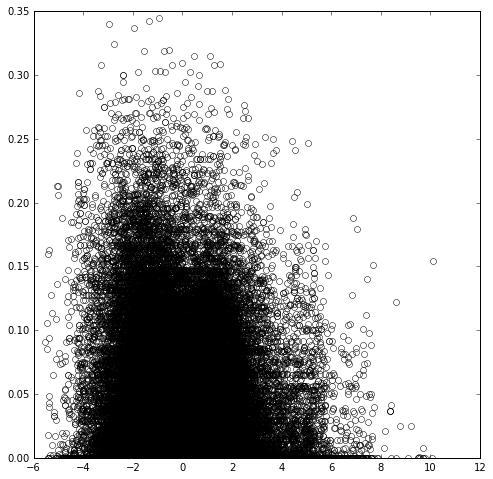

In [51]:
plt.figure(figsize=(8, 8))
plt.plot(score_access_adjusted, fst, marker='o', mfc='none', linestyle=' ');

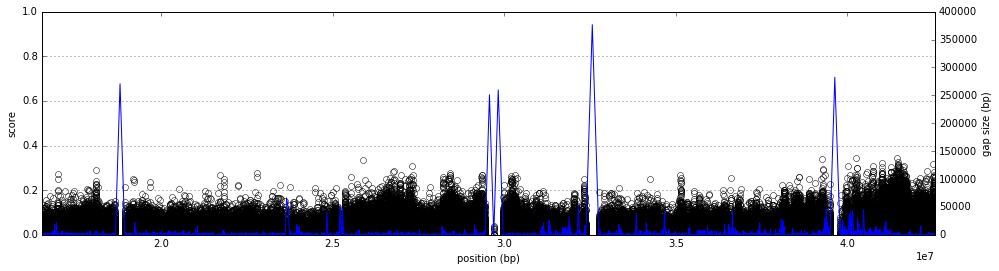

In [52]:
plot_score_gap(fst, pos_seg, ylim=(0, 1))

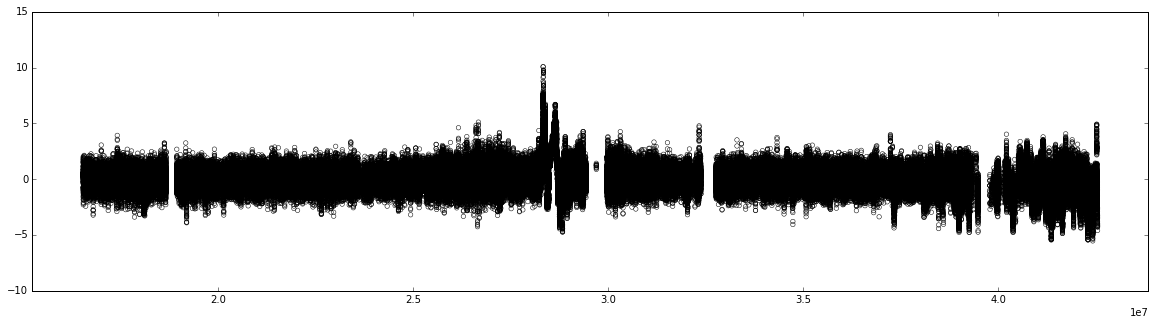

In [65]:
x = pos_seg
y = score_access_adjusted
plt.figure(figsize=(20, 5))
plt.scatter(x, y, s=20, linewidth=0.5, facecolor='none')
plt.autoscale(axis='x', tight=True)

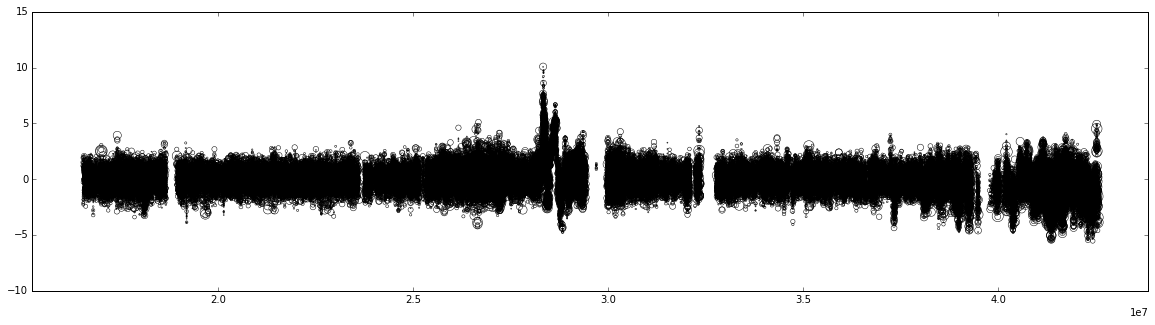

In [77]:
x = pos_seg
y = score_access_adjusted
s = (1 + 40 * fst) ** 2
plt.figure(figsize=(20, 5))
plt.scatter(x, y, s=s, linewidth=.5, facecolor='none')
plt.autoscale(axis='x', tight=True)

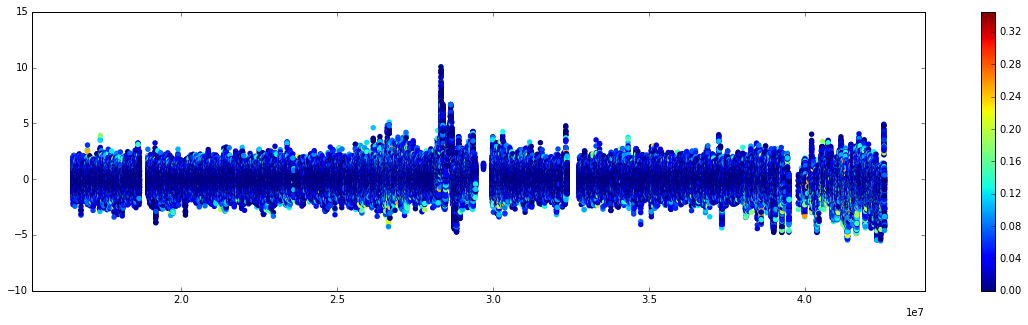

In [69]:
x = pos_seg
y = score_access_adjusted
c = fst
plt.figure(figsize=(20, 5))
plt.scatter(x, y, s=20, c=c, linewidth=0, cmap='jet')
plt.autoscale(axis='x', tight=True)
plt.colorbar();

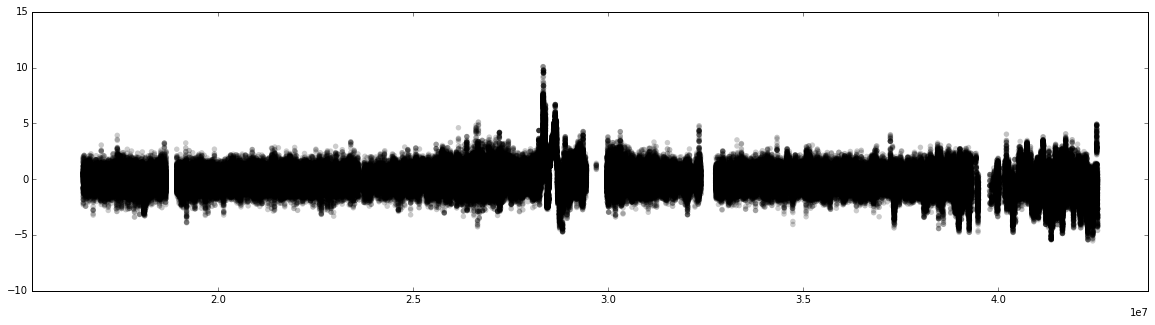

In [75]:
c = np.zeros((len(fst), 4))
# c[:, 2] = 1.0
c[:, 3] = .2 + (.8 * fst / np.max(fst))
x = pos_seg
y = score_access_adjusted
plt.figure(figsize=(20, 5))
plt.scatter(x, y, s=30, c=c, linewidth=0)
plt.autoscale(axis='x', tight=True);

In [104]:
c = np.zeros((len(score_access_adjusted), 4))
a = np.zeros_like(score_access_adjusted)
f = ~np.isnan(score_access_adjusted)
a[f] = np.abs(score_access_adjusted[f])
a = a.clip(min=2, max=4) - 2
c[:, 3] = a / np.max(a)
c[:, 3]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

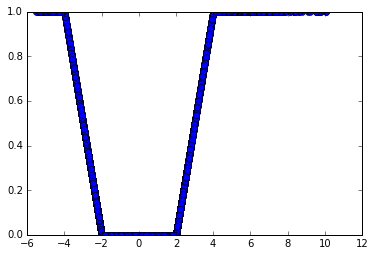

In [105]:
plt.plot(score_access_adjusted, c[:, 3], 'bo');

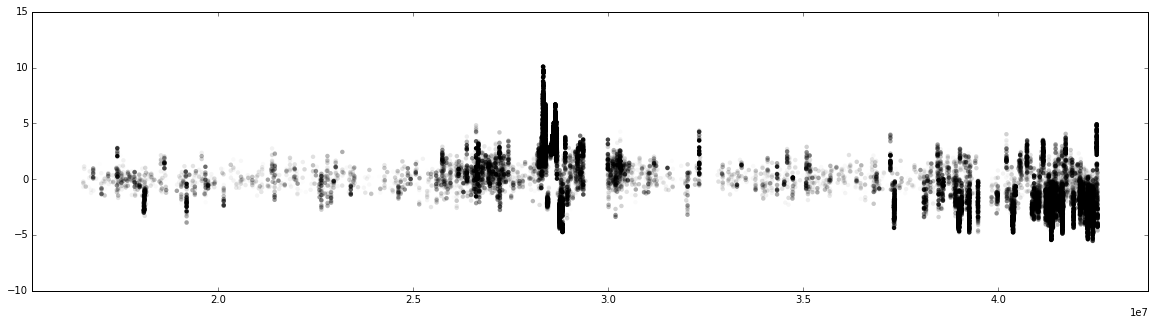

In [106]:
x = pos_seg
y = score_access_adjusted
plt.figure(figsize=(20, 5))
plt.scatter(x, y, s=20, c=c, linewidth=0)
plt.autoscale(axis='x', tight=True);

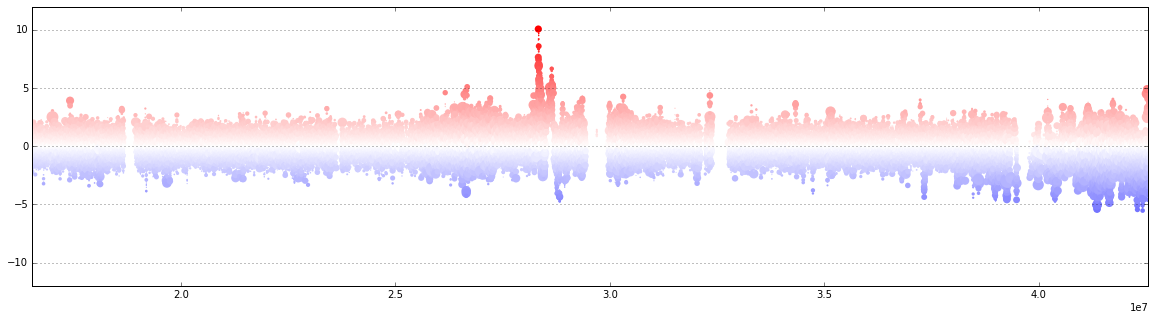

In [126]:
x = pos_seg
y = score_access_adjusted
s = (1 + 40 * fst) ** 2
c = score_access_adjusted
plt.figure(figsize=(20, 5))
plt.scatter(x, y, s=s, c=c, linewidth=0, cmap='bwr', vmin=-10, vmax=10)
plt.xlim(pos_seg[0], pos_seg[-1])
plt.ylim(-12, 12)
plt.grid(axis='y');

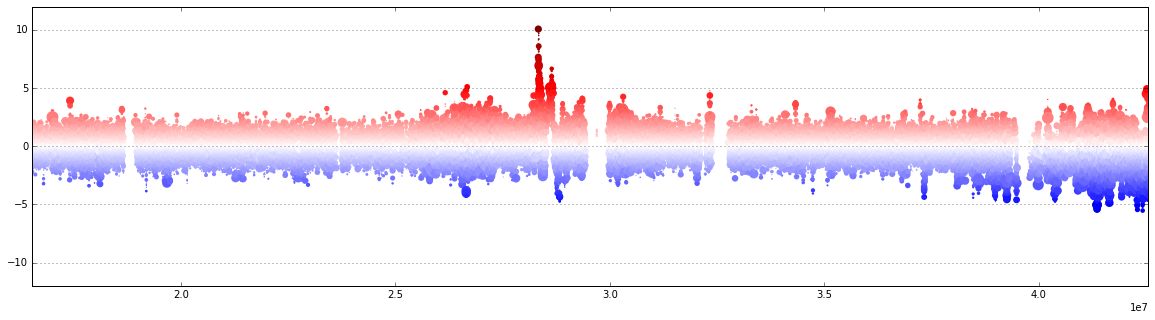

In [124]:
x = pos_seg
y = score_access_adjusted
s = (1 + 40 * fst) ** 2
c = score_access_adjusted
plt.figure(figsize=(20, 5))
plt.scatter(x, y, s=s, c=c, linewidth=0, cmap='seismic', vmin=-10, vmax=10)
plt.xlim(pos_seg[0], pos_seg[-1])
plt.ylim(-12, 12)
plt.grid(axis='y');

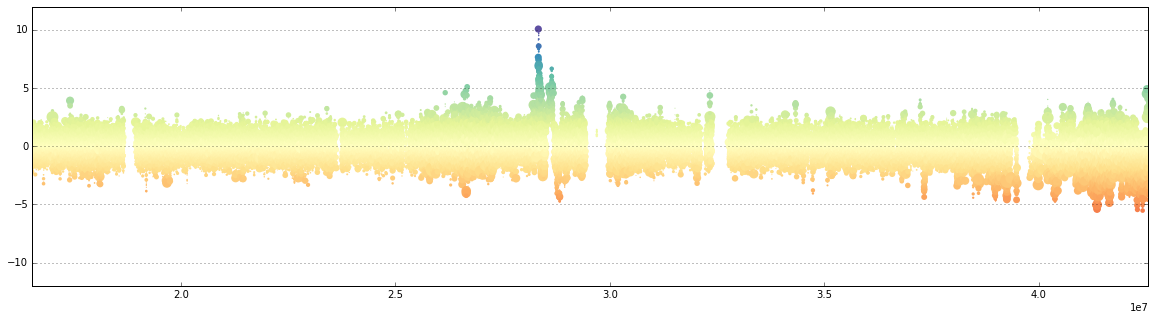

In [125]:
x = pos_seg
y = score_access_adjusted
s = (1 + 40 * fst) ** 2
c = score_access_adjusted
plt.figure(figsize=(20, 5))
plt.scatter(x, y, s=s, c=c, linewidth=0, cmap='Spectral', vmin=-10, vmax=10)
plt.xlim(pos_seg[0], pos_seg[-1])
plt.ylim(-12, 12)
plt.grid(axis='y');

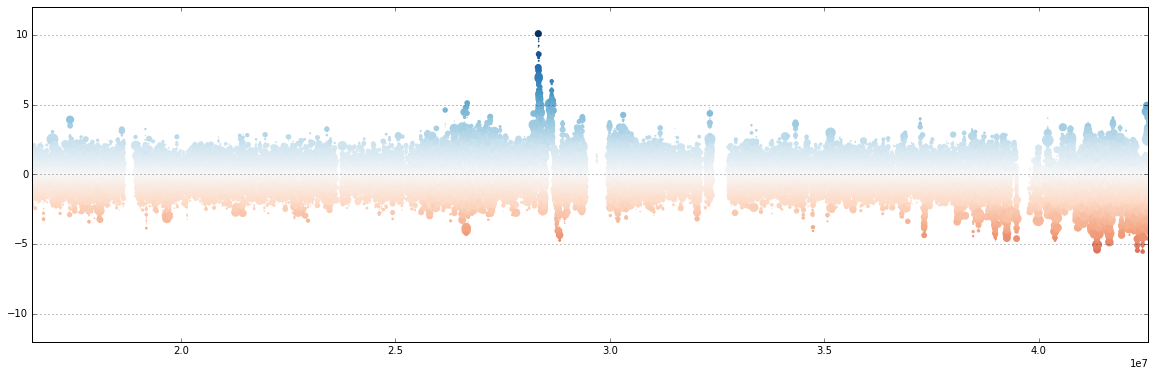

In [128]:
x = pos_seg
y = score_access_adjusted
s = (1 + 40 * fst) ** 2
c = score_access_adjusted
plt.figure(figsize=(20, 6))
plt.scatter(x, y, s=s, c=c, linewidth=0, cmap='RdBu', vmin=-10, vmax=10)
plt.xlim(pos_seg[0], pos_seg[-1])
plt.ylim(-12, 12)
plt.grid(axis='y');

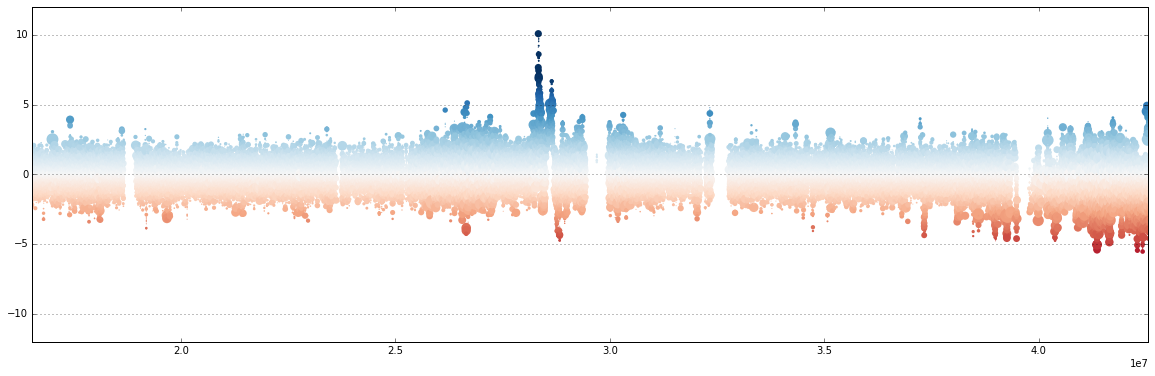

In [129]:
x = pos_seg
y = score_access_adjusted
s = (1 + 40 * fst) ** 2
c = score_access_adjusted
plt.figure(figsize=(20, 6))
plt.scatter(x, y, s=s, c=c, linewidth=0, cmap='RdBu', vmin=-7, vmax=7)
plt.xlim(pos_seg[0], pos_seg[-1])
plt.ylim(-12, 12)
plt.grid(axis='y');